# Forcing an Output in a Neural Network 2
See my previous notebook for the quick proof of concept. In that notebook, I explored forcing an output on a toy neural network, but admittedly, the network was not a state-of-the-art model, and it was only trained for a few minutes. What would happen if the same approach was taken with a more robust pretrained model, like the [Inception network](https://keras.io/api/applications/inceptionv3/)? The goal of this notebook is to show that the method used for finding the best input image can work on robust networks in addition to the toy example that was used before.

## Preparing the pretrained model

The first step here is to start using the InceptionV3 network, which was trained for the ILSVRC classification challenge that has 1000 image classes in it. Using default parameters, the input images are 229x229 pixel color images (3 channel). If you do not already have the model weights downloaded, the API call will do that for you.

In [1]:
import tensorflow.keras as keras
import tensorflow as tf

inception_net = keras.applications.InceptionV3(weights="imagenet")
inception_net.trainable = False # freeze model as-is. don't let training mutate it.

input_width = input_height = 229
input_channels = 3
inception_net_input_dimension = (input_width, input_height, input_channels)

To show that the model works as expected out of the box, we can feed it an image and see what comes out. I will be using this [gaint panda image](https://commons.wikimedia.org/wiki/File:Grosser_Panda.JPG) from Wikipedia, and I will be modifying it from its original form to fit into the 229x229x3 dimensions. The resize operation is simply squashing the image, so it'll look narrower than normal, but that's fine for this demo.

Photo credit and license: J. Patrick Fischer / CC BY-SA (https://creativecommons.org/licenses/by-sa/3.0)

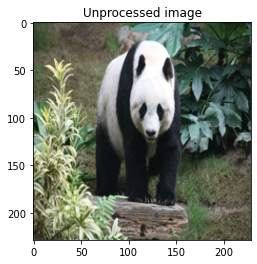

In [2]:
# advice for importing an image straight from a URL https://stackoverflow.com/a/23489503
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
from PIL import Image
from keras.applications.inception_v3 import decode_predictions, preprocess_input

# Photo credit and license: J. Patrick Fischer / CC BY-SA (https://creativecommons.org/licenses/by-sa/3.0)
image_url = "https://upload.wikimedia.org/wikipedia/commons/0/0f/Grosser_Panda.JPG"
response = requests.get(image_url)
panda = np.array(Image.open(BytesIO(response.content)).resize((input_width, input_height)))
preprocessed_panda = preprocess_input(panda) # normalize image betweeen values -1.0 and 1.0 for network

# visualization
plt.title("Unprocessed image")
plt.imshow(panda)
plt.show()

Now that the example image has been preprocessed, it can be fed into the pretrained network. As expected, the model predicts correctly that it is a giant panda, and its second best inference is a lesser panda. I don't think there's any surprise here.

In [3]:
# network expects a 4-dimensional array: essentially an array of color images. change to that shape
panda = preprocessed_panda.reshape((1, *preprocessed_panda.shape))
panda_prediction = inception_net(panda).numpy()
print(decode_predictions(panda_prediction, 2))

[[('n02510455', 'giant_panda', 0.9999925), ('n02509815', 'lesser_panda', 7.1350896e-06)]]


## Creating a generator model

Because the pretrained model is already in code, we can use the same training system to overfit a model on top of the pretrained model to force an output of our choosing. The model does not need to be complex either. The one I make below takes in a single number (1.0) connected to a Dense layer, and that is immediately reshaped into the generated image.

The generator model and the pretrained model are combined into a single "testbed" model so that they can be trained as a single entity. To note: the Inception model was already frozen when it was imported above with `inception_net.trainable = False`, so the only model that mutates is the generator. Having the pretrained model mutate defeats the purpose of generating images to force its output, so it is necessary to freeze its weights. After training is complete, we can use the models seperately again, so the generator will make an image when it is given an input of 1.0, and the Inception model is unchanged.

In [4]:
# create the image generator model
from functools import reduce

image_generator = keras.models.Sequential([
    # image is allowed values -1.0 to 1.0, so tanh can be used to cap values there automatically
    keras.layers.Dense(reduce(lambda a, b: a*b, inception_net_input_dimension), activation='tanh', input_shape=(1,)),
    keras.layers.Reshape(inception_net_input_dimension)
])

testbed_model = keras.models.Sequential([
    image_generator, # model that creates an input image
    inception_net # pretrained model. it does not mutate or "train" during the training operation
])

testbed_model.compile(
    loss='sparse_categorical_crossentropy', # allows us to use a whole-number label instead of a 1-hot vector
    optimizer= keras.optimizers.RMSprop(), # using this because the Inception network paper used this optimizer
    metrics=['accuracy'],
)

## Creating "training data"

The training dataset is very simple relative to what is needed to train the original model. Instead of using a diverse set of inputs to make a generalized model, the goal here is to overfit the generator model so that it gives the output we want. Because that's all we want, and because the generator takes in a single number, we can create a mapping of the training dataset input (literally just the number 1.0) to the training label, which is the ID of the output we want to generate. In this case, I want to cause the output to be a Samoyed, because who doesn't like big fluffy dogs?

We can train in batches of 1 because creating more fake examples does not actually optimize the training. Because all inputs will be identical (the number 1.0), there will be no difference in the error gradients that are backpropagated into the generator model. The average of identical values is the value, so we only need to pass in a single sample, and this will be the only sample per epoch. The model will converge after a handful of epochs, but we can keep it training to overfit more and more to see how the generated image changes over time.

In [5]:
# create "training data"

# labels retrieved from https://github.com/keras-team/keras-applications/blob/e8a7474111e5b77d340d2c4204130b83e9ed69b8/keras_applications/imagenet_utils.py#L14-L15
# As an example, I want to see this:
#    "258": [
#        "n02111889",
#        "Samoyed"
#    ]
number_of_samples = 1
training_input = np.ones((number_of_samples, 1), np.float32) # one single input, a 2-dimensional array of a single 1.0
desired_label = 258 # Change me to try different output
training_label = np.ones((number_of_samples, 1), np.int64) * desired_label
training_dataset = tf.data.Dataset.from_tensor_slices((training_input, training_label))
training_dataset = training_dataset.batch(1)

## Train the model

There isn't a lot to explain here. With the dataset you just generated, now you can adapt your model to produce an image that will force that output out of the Inception network.

**NOTICE**: If you want to try producing a different label, you will need to rerun both the [Creating a generator model](#Creating-a-generator-model) and [Creating "training data"](#Creating-"training-data") cells to generate a clean slate generator model. If you don't do that, you will be attempting to train a model that was overfit to the previous label and it may not converge to the newer label.

In [6]:
testbed_model.fit(
    training_dataset,
    epochs=100
)

Epoch 1/100
1/1 [==============================] - 0s 1000us/step - loss: 7.2438 - accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 5.2921 - accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 0s 4ms/step - loss: 7.5018 - accuracy: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 0s 4ms/step - loss: 4.9686 - accuracy: 0.0000e+00
Epoch 5/100
1/1 [==============================] - 0s 6ms/step - loss: 3.0064 - accuracy: 0.0000e+00
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 0.7142 - accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 0.0612 - accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 0s 5ms/step - loss: 1.3219e-04 - accuracy: 1.0000
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 1.2898e-04 - accuracy: 1.0000
Epoch 10/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2576e-04 - accuracy: 1

1/1 [==============================] - 0s 5ms/step - loss: 1.3351e-05 - accuracy: 1.0000
Epoch 78/100
1/1 [==============================] - 0s 5ms/step - loss: 1.2994e-05 - accuracy: 1.0000
Epoch 79/100
1/1 [==============================] - 0s 4ms/step - loss: 1.2517e-05 - accuracy: 1.0000
Epoch 80/100
1/1 [==============================] - 0s 3ms/step - loss: 1.2159e-05 - accuracy: 1.0000
Epoch 81/100
1/1 [==============================] - 0s 6ms/step - loss: 1.1563e-05 - accuracy: 1.0000
Epoch 82/100
1/1 [==============================] - 0s 5ms/step - loss: 1.1325e-05 - accuracy: 1.0000
Epoch 83/100
1/1 [==============================] - 0s 2ms/step - loss: 1.1086e-05 - accuracy: 1.0000
Epoch 84/100
1/1 [==============================] - 0s 5ms/step - loss: 1.0729e-05 - accuracy: 1.0000
Epoch 85/100
1/1 [==============================] - 0s 3ms/step - loss: 1.0490e-05 - accuracy: 1.0000
Epoch 86/100
1/1 [==============================] - 0s 6ms/step - loss: 9.8943e-06 - accuracy: 

## Visualizing the image

One the network is trained, you can now use the "training" input to generate the image that produces the expected output label. Because the Inception network accepts images that have been normalized to values between -1.0 and 1.0, I created a function to scale them from 0.0 to 1.0 so that matplotlib does not clip the values. The full image is shown along with its color channel decomposition.

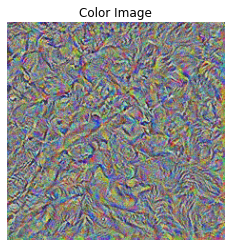

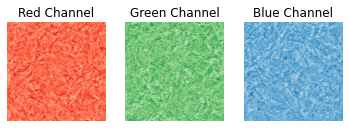

In [7]:
import matplotlib.pyplot as plt
example_image = image_generator(training_input)

def denormalize_image(image):
    # viewable image is generated image (min -1.0, max 1.0) mapped to min 0.0, max 1.0
    return ((image - np.min(image)) / (np.max(image) - np.min(image)))

image_viewable = denormalize_image(example_image[0])
plt.axis('off')
plt.title("Color Image")
plt.imshow(image_viewable)
plt.show()

image_viewable_rgb = np.array(image_viewable).reshape(input_channels, input_width, input_height)
plt.subplot(1, 3, 1)
plt.axis('off')
plt.title("Red Channel")
plt.imshow(image_viewable_rgb[0], cmap="Reds")
plt.subplot(1, 3, 2)
plt.axis('off')
plt.title("Green Channel")
plt.imshow(image_viewable_rgb[1], cmap="Greens")
plt.subplot(1, 3, 3)
plt.axis('off')
plt.title("Blue Channel")
plt.imshow(image_viewable_rgb[2], cmap="Blues")
plt.show()

## Validating that the generator model works

Now that we've generated an image, we can expect it to output our label, but what about other labels? For me, it was not surprising that the top result was the label used in training (that was the purpose), but it **was** surprising to me that the other entries in the top 5 results *were also dogs (or very fluffy animals)*. I expected that the rest would be random results as a side effect of brute forcing the image, but I can picture at least two scenarios to cause this:
1. The generated image acts more like a normal image than I expected
2. The Inception network weights have similar activations for Samoyeds as the other labels

All that said, the next greatest confidence value is 8 magnitudes smaller (much closer to 0.0 than 1.0), so that's not to say that the model is confusing them at all, but it is interesting to see the similarities in labels with such a seemingly random-looking input image.

In [8]:
real_output = inception_net(example_image)
preds = decode_predictions(real_output.numpy(), 10) # get top 10 inferences
for i in range(len(preds[0])):
    print("{}. {}: {}".format(i, preds[0][i][1], preds[0][i][2]))

0. Samoyed: 0.9999939203262329
1. Great_Pyrenees: 2.7354776648280676e-06
2. chow: 1.2059214213877567e-06
3. kuvasz: 6.000159373797942e-07
4. Arctic_fox: 3.705344511217845e-07
5. Persian_cat: 2.470764286499616e-07
6. West_Highland_white_terrier: 7.468526064258185e-08
7. Pomeranian: 6.842167721288206e-08
8. standard_poodle: 4.658873820062581e-08
9. keeshond: 3.382147539809921e-08
